In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class PolymerMotion:
    def __init__(self, num_particles, spring_constants, mass=1.0, dt=0.01, total_time=10):
        self.num_particles = num_particles
        self.spring_constants = np.asarray(spring_constants)
        self.mass = np.full(num_particles, mass) if not isinstance(mass, np.ndarray) else mass
        self.dt = dt
        self.total_time = total_time
        self.time_steps = int(total_time / dt)

        # Initialize particle positions in 2D and zero velocities
        self.positions = np.random.rand(num_particles, 2)
        self.velocities = np.zeros((num_particles, 2))
        self.trajectory = np.zeros((self.time_steps, num_particles, 2))

    def forces(self, positions):
        """Compute spring forces between particles based on Hooke's law."""
        F = np.zeros((self.num_particles, 2))
        for i in range(self.num_particles):
            for j in range(i + 1, self.num_particles):
                displacement = positions[j] - positions[i]
                distance = np.linalg.norm(displacement)
                if distance > 0:
                    force_magnitude = self.spring_constants[i] * displacement / distance
                    F[i] += force_magnitude
                    F[j] -= force_magnitude  # Newton's third law
        return F

    def motion_equations(self, y, t):
        """ODE system: returns derivatives of position and velocity."""
        pos = y[:self.num_particles * 2].reshape((self.num_particles, 2))
        vel = y[self.num_particles * 2:].reshape((self.num_particles, 2))

        F = self.forces(pos)
        damping = -0.1 * vel  # simple linear damping

        dydt = np.zeros_like(y)
        dydt[:self.num_particles * 2] = vel.flatten()
        dydt[self.num_particles * 2:] = ((F + damping) / self.mass[:, None]).flatten()

        return dydt

    def simulate(self):
        """Run the simulation and return the trajectory."""
        y0 = np.hstack((self.positions.flatten(), self.velocities.flatten()))
        t = np.linspace(0, self.total_time, self.time_steps)
        sol = odeint(self.motion_equations, y0, t)
        self.trajectory = sol[:, :self.num_particles * 2].reshape((-1, self.num_particles, 2))
        return self.trajectory

    def generate_transition_matrix(self):
        """Construct a transition matrix based on displacement similarity between particles."""
        cumulative_displacements = np.zeros((self.num_particles, self.num_particles))

        for t in range(1, self.time_steps):
            for i in range(self.num_particles):
                for j in range(self.num_particles):
                    displacement = np.linalg.norm(self.trajectory[t, i] - self.trajectory[t - 1, j])
                    cumulative_displacements[i, j] += displacement

        # Invert cumulative displacement to get similarity (smaller displacement = higher prob)
        with np.errstate(divide='ignore'):
            transition_matrix = np.where(cumulative_displacements > 0, 1.0 / cumulative_displacements, 0.0)

        # Normalize rows to make valid transition probabilities
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_matrix = np.where(row_sums > 0, transition_matrix / row_sums, 1.0 / self.num_particles)

        return transition_matrix

    def plot_trajectories(self):
        """Plot X and Y positions of particles over time."""
        time = np.linspace(0, self.total_time, self.time_steps)
        plt.figure(figsize=(12, 6))

        for i in range(self.num_particles):
            plt.plot(time, self.trajectory[:, i, 0], label=f'Particle {i+1} X', linestyle='-')
            plt.plot(time, self.trajectory[:, i, 1], label=f'Particle {i+1} Y', linestyle='--')

        plt.title('Particle Trajectories Over Time')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.legend()
        plt.grid()
        plt.show()


def generate_correlated_random_walks(polymer_model, num_walks, num_steps, target_corr_matrix):
    """
    Generate correlated random walks using a transition matrix derived from a polymer simulation.
    :param polymer_model: Simulated PolymerMotion instance.
    :param num_walks: Number of walks to generate.
    :param num_steps: Number of steps in each walk.
    :param target_corr_matrix: Desired correlation matrix between walks.
    """
    # Check if the correlation matrix is valid
    assert np.all(np.linalg.eigvals(target_corr_matrix) > 0), "Correlation matrix must be positive definite."

    # Cholesky decomposition
    L = np.linalg.cholesky(target_corr_matrix)

    # Build transition matrix from polymer dynamics
    transition_matrix = polymer_model.generate_transition_matrix()

    # Generate independent discrete state walks using the transition probabilities
    independent_walks = np.zeros((num_walks, num_steps))
    for i in range(num_walks):
        state = np.random.choice(polymer_model.num_particles)
        walk = [state]
        for _ in range(num_steps - 1):
            state = np.random.choice(polymer_model.num_particles, p=transition_matrix[state])
            walk.append(state)
        independent_walks[i] = walk

    # Transform to correlated walks: (L @ independent_walks) should be transposed
    correlated_walks = (L @ independent_walks)  # Shape: (num_steps, num_walks)

    return correlated_walks

In [2]:
!pip install --upgrade mesa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 3.6 MB/s eta 0:00:00


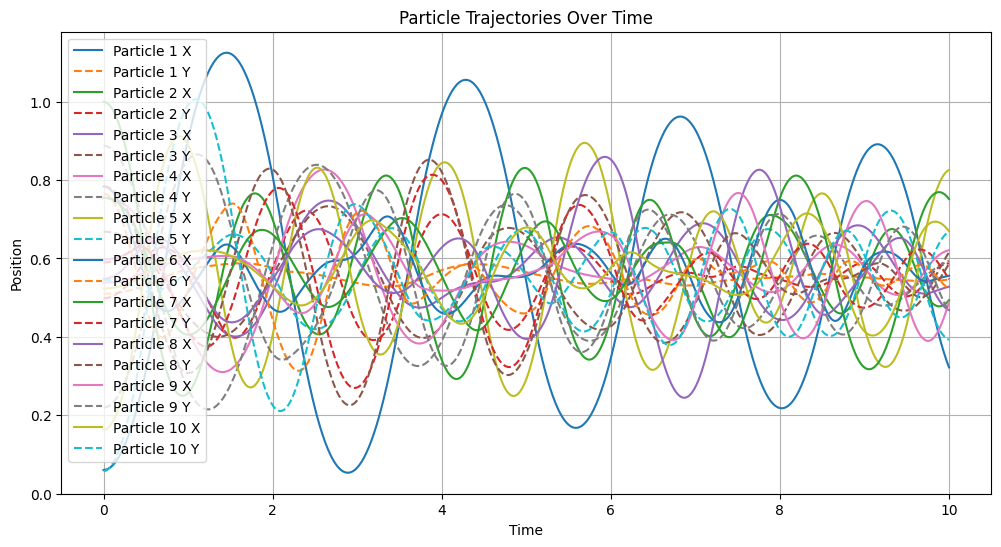

In [3]:
# Parameters
num_particles = 10
spring_constants = np.random.rand(num_particles)  # Random spring constants for each particle
polymer_model = PolymerMotion(num_particles, spring_constants)

# Simulate the polymer motion
trajectory = polymer_model.simulate()

# Plot the trajectories as a function of time
polymer_model.plot_trajectories()

In [4]:
#Generate a correlation matrix from Higham's algorithm

import numpy as np
from scipy.linalg import eigh

# Step 1: Generate a random matrix and symmetrize it
def generate_random_correlation_matrix(n):
    # Generate a random matrix
    A = np.random.rand(n, n)

    # Symmetrize the matrix
    A = (A + A.T) / 2

    # Step 2: Force diagonal elements to 1 (for correlation matrix)
    np.fill_diagonal(A, 1)

    return A

# Step 3: Apply Higham's algorithm to ensure the matrix is PSD
def higham_psd(matrix, tol=1e-8):
    """
    Adjusts the matrix to be positive semi-definite using Higham's algorithm.
    Parameters:
    - matrix: Input matrix to be corrected.
    - tol: Tolerance for eigenvalue correction.
    """
    # Eigen decomposition (guaranteed to work for symmetric matrices)
    eigvals, eigvecs = eigh(matrix)

    # Replace negative eigenvalues or those below tolerance with zeros (for PSD)
    eigvals = np.clip(eigvals, tol, None)

    # Reconstruct the matrix from modified eigenvalues and eigenvectors
    psd_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # Step 4: Rescale to ensure diagonals are exactly 1
    D = np.sqrt(np.diag(psd_matrix))
    psd_matrix = psd_matrix / np.outer(D, D)

    # Fix numerical issues with diagonal exactly being 1
    np.fill_diagonal(psd_matrix, 1)
    return psd_matrix

In [5]:
# Step 5: Generate a random matrix and make it a PSD correlation matrix
n = 1000  # Number of variables
random_matrix = generate_random_correlation_matrix(n)
psd_matrix = higham_psd(random_matrix)

# Example of generating correlated random walks
target_corr_matrix = psd_matrix

In [6]:
print("target_corr_matrix shape:", np.shape(target_corr_matrix))

target_corr_matrix shape: (1000, 1000)


In [7]:
transition_matrix = polymer_model.generate_transition_matrix()
num_walks = 1000
num_steps = 5000
random_walks = generate_correlated_random_walks(polymer_model, num_walks, num_steps, target_corr_matrix)

In [8]:
#Function to rescale the walks

def rescale_to_limits(data, lower_limit, upper_limit):

    min_val = np.min(data)
    max_val = np.max(data)

    # Rescale using min-max normalization
    rescaled_data = (data - min_val) / (max_val - min_val)  # Normalize to [0, 1]
    rescaled_data = rescaled_data * (upper_limit - lower_limit) + lower_limit  # Scale to [lower_limit, upper_limit]

    return rescaled_data

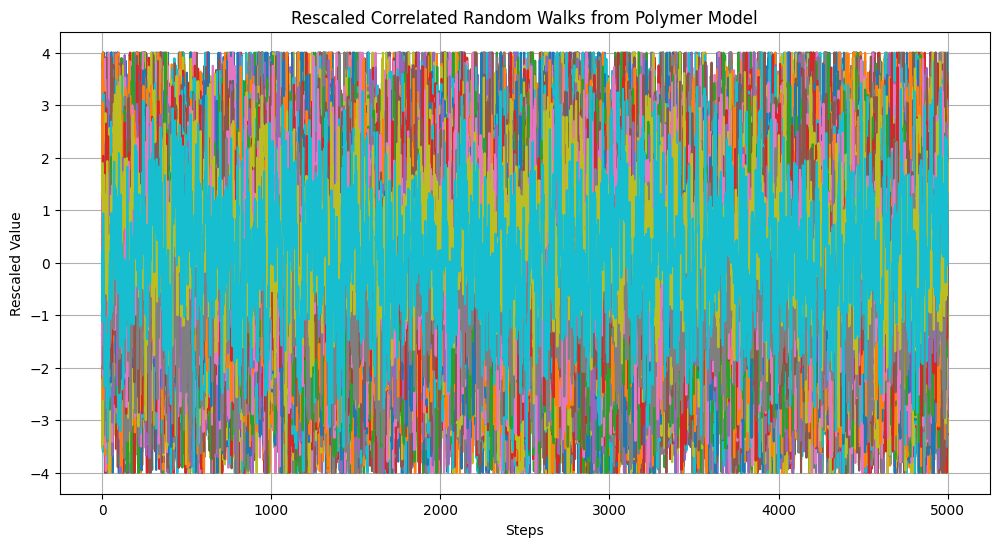

In [9]:
# Rescale each random walk to the range [lower_limit, upper_limit]
lower_limit = -4.0  # Specify the lower limit
upper_limit = 4.0  # Specify the upper limit

plt.figure(figsize=(12, 6))
r=[]

for i in range(random_walks.shape[0]):
    rescaled_walk = rescale_to_limits(random_walks[i], lower_limit, upper_limit)
    r.append(rescaled_walk)
    plt.plot(rescaled_walk, label=f'Walk {i+1}')

plt.title('Rescaled Correlated Random Walks from Polymer Model')
plt.xlabel('Steps')
plt.ylabel('Rescaled Value')
plt.grid()
plt.show()

In [10]:
#Randomly shuffle the generated random walks

r_shuffled = []

for i in range(len(r)):
    # Make a copy of r[i] to avoid modifying the original array
    temp = r[i].copy()
    np.random.shuffle(temp)
    r_shuffled.append(temp)

In [11]:
#This code is experimental. Might need revision.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series

        for t in range(1, num_steps):
            dW = np.random.normal(size=self.num_nodes) * np.sqrt(dt)
            correlated_noise = np.dot(self.correlation_decomposition, dW)

            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise

            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)

            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion

            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None

    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]

    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])

            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()

            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)

            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants

    return best_params, best_error

In [12]:
import numpy as np

num_nodes = 20
dt = 0.01
num_steps = 1000

# Generate a high correlation matrix for 20 nodes
# For simplicity, we create a matrix where correlations decay with node distance
base_corr = 0.9
decay_rate = 0.05

target_correlation_matrix = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(num_nodes):
        # Correlation decreases as nodes get further apart
        target_correlation_matrix[i, j] = base_corr ** abs(i - j)
# Make sure diagonal is exactly 1
np.fill_diagonal(target_correlation_matrix, 1.0)

# Define parameter ranges for coupling constants as before
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # Adjust as needed

# Run grid search for best params - ensure your grid_search function supports 20 nodes!
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate time series with best params
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [13]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0.6]
Best error: 20.46758894160107


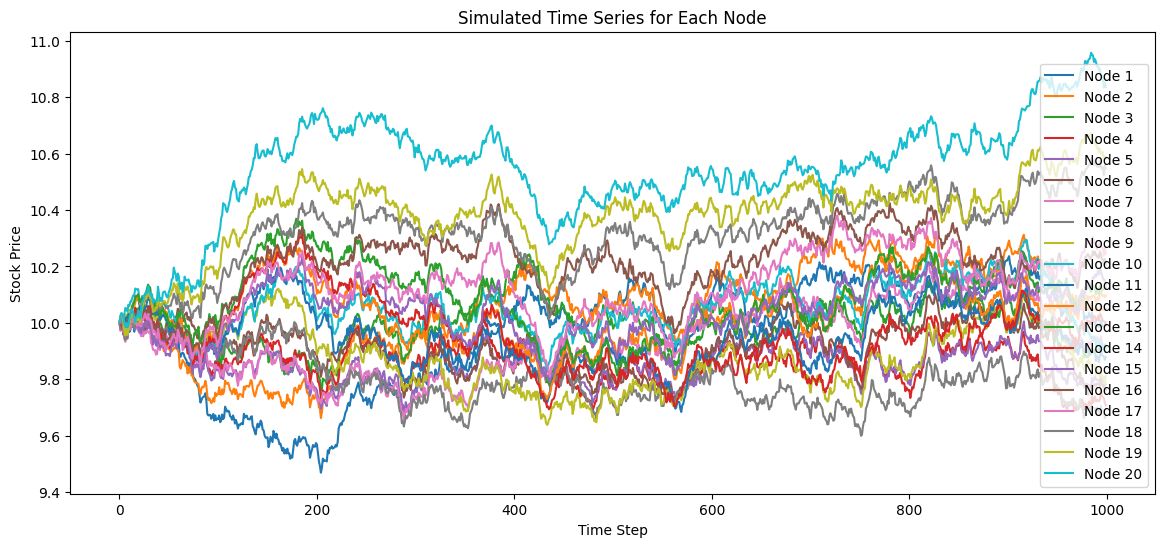

In [14]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

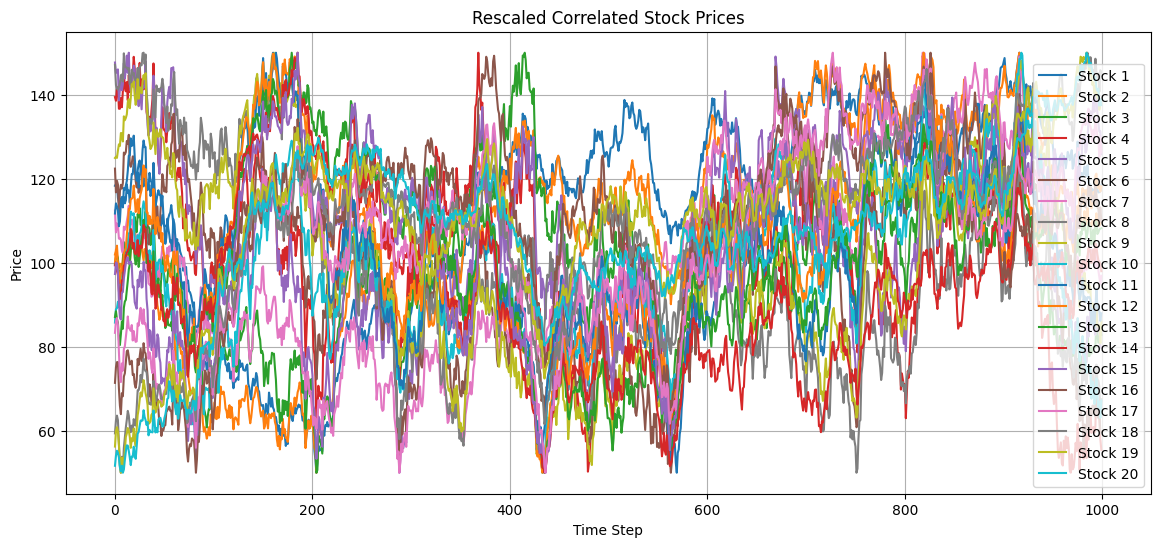

In [15]:
import pandas as pd
# Rescale to range [50, 150]
min_price, max_price = 50, 150
rescaled_prices = np.zeros_like(t_series.time_series)

for i in range(num_nodes):
    rescaled_prices[i] = np.interp(t_series.time_series[i, :], (t_series.time_series[i, :].min(), t_series.time_series[i, :].max()), (min_price, max_price))

# Optional: Store as DataFrame
dates = pd.date_range(start='2023-01-01', periods=num_steps, freq='D')
rescaled_df = pd.DataFrame({f'Stock_{i+1}': rescaled_prices[i] for i in range(num_nodes)})
rescaled_df.insert(0, 'Date', dates)

# Plot rescaled prices
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(rescaled_prices[i], label=f'Stock {i+1}')
plt.title('Rescaled Correlated Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import numpy as np

class AdvancedMarketMaker:
    def __init__(self, node_index, initial_cash=10_000, base_spread=1.0, inventory_limit=50):
        self.node_index = node_index
        self.cash = initial_cash
        self.inventory = 0
        self.base_spread = base_spread
        self.inventory_limit = inventory_limit
        self.pnl_history = []

    def quote_prices(self, mid_price, volatility):
        """
        Generate dynamic bid and ask quotes, adjusted for inventory and volatility.
        """
        # Inventory skew moves prices away from riskier positions
        inventory_bias = 0.1 * self.inventory / self.inventory_limit
        spread = self.base_spread + 0.5 * volatility

        bid_price = mid_price - (spread / 2) - inventory_bias
        ask_price = mid_price + (spread / 2) - inventory_bias

        return bid_price, ask_price

    def execute_trade(self, bid_hit: bool, ask_lifted: bool, bid_price: float, ask_price: float):
        """
        Update inventory and cash based on which quotes were executed.
        """
        if bid_hit:
            self.inventory += 1
            self.cash -= bid_price

        if ask_lifted:
            self.inventory -= 1
            self.cash += ask_price

    def calculate_pnl(self, mid_price):
        """
        Mark-to-market PnL: realized cash + unrealized inventory value.
        """
        return self.cash + self.inventory * mid_price

    def record_pnl(self, mid_price):
        """
        Log current total PnL.
        """
        self.pnl_history.append(self.calculate_pnl(mid_price))

In [17]:
import numpy as np
import pandas as pd

# Assuming AdvancedMarketMaker class is already defined with methods:
# - quote_prices(mid_price, volatility) -> (bid, ask)
# - execute_trade(bid_hit, ask_lifted, bid, ask)
# - record_pnl(mid_price)
# - attributes: inventory, cash, pnl_history

class MarketEnvironment:
    def __init__(self, mid_price_series, volatility_series=None):
        self.history = []
        self.mid_prices = mid_price_series
        self.num_nodes, self.num_steps = mid_price_series.shape
        self.time_step = 0

        # Use provided volatility or set constant default
        if volatility_series is not None:
            self.volatility = volatility_series
        else:
            self.volatility = np.full_like(mid_price_series, 0.5)

        # Initialize market maker agents
        self.agents = [
            AdvancedMarketMaker(node_index=node)
            for node in range(self.num_nodes)
        ]

    def simulate_market_order_flow(self):
        """
        Simulate random external buy/sell pressure hitting quotes.
        Returns: (bid_hit, ask_lifted)
        """
        buy_pressure = np.random.rand() > 0.7  # 30% chance buy
        sell_pressure = np.random.rand() > 0.7 # 30% chance sell
        return sell_pressure, buy_pressure

    def step(self):
        if self.time_step >= self.num_steps - 1:
            return

        t = self.time_step
        for node in range(self.num_nodes):
            mid = self.mid_prices[node, t]
            vol = self.volatility[node, t]

            agent = self.agents[node]
            bid, ask = agent.quote_prices(mid, vol)

            bid_hit, ask_lifted = self.simulate_market_order_flow()
            agent.execute_trade(bid_hit, ask_lifted, bid, ask)
            agent.record_pnl(mid)

            # Log this step's data for analysis/training
            self.history.append({
                'time_step': t,
                'node': node,
                'mid_price': mid,
                'volatility': vol,
                'bid': bid,
                'ask': ask,
                'bid_hit': bid_hit,
                'ask_lifted': ask_lifted,
                'inventory': agent.inventory,
                'cash': agent.cash,
                'pnl': agent.pnl_history[-1]
            })

        self.time_step += 1

    def run(self):
        """
        Run the simulation over all timesteps.
        """
        for _ in range(self.num_steps - 1):
            self.step()

    def export_history(self, filename='abm_trading_history.csv'):
        df = pd.DataFrame(self.history)
        df.to_csv(filename, index=False)
        print(f"Saved simulation history to {filename}")

In [18]:
# === Your rescaled_prices data with shape (num_nodes, num_steps) ===
mid_prices = rescaled_prices  # your existing numpy array
num_nodes, num_steps = mid_prices.shape

# Optional: generate synthetic volatility if not provided
volatility = np.abs(np.random.normal(0.5, 0.2, size=(num_nodes, num_steps)))

# Create and run the market environment simulation
market = MarketEnvironment(mid_price_series=mid_prices, volatility_series=volatility)
market.run()

# Save the trading history for later analysis or training MARL agent
market.export_history('abm_trading_history.csv')

Saved simulation history to abm_trading_history.csv


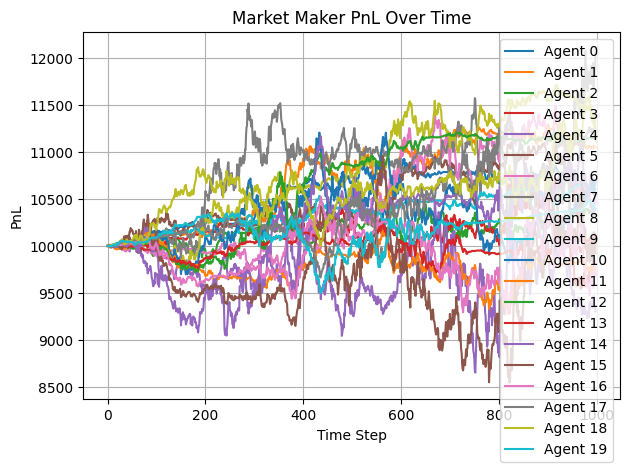

In [19]:
import matplotlib.pyplot as plt

for i, agent in enumerate(market.agents):
    plt.plot(agent.pnl_history, label=f"Agent {i}")
plt.title("Market Maker PnL Over Time")
plt.xlabel("Time Step")
plt.ylabel("PnL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import random
from collections import deque
from tensorflow.keras import layers, models, optimizers

class DynaQAgent:
    def __init__(self, n_time_steps, max_inventory, max_offset,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 learning_rate=0.001, discount_factor=0.99,
                 buffer_size=20000, batch_size=64,
                 dyna_planning_steps=50):
        self.n_time_steps = n_time_steps
        self.max_inventory = max_inventory
        self.max_offset = max_offset

        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.lr = learning_rate
        self.gamma = discount_factor

        self.batch_size = batch_size
        self.dyna_planning_steps = dyna_planning_steps

        self.action_space = [(b, a) for b in range(-max_offset, max_offset + 1)
                             for a in range(-max_offset, max_offset + 1)]
        self.action_size = len(self.action_space)
        self.state_dim = 2  # normalized (time_step, inventory)

        # Q-function networks
        self.model = self.build_q_model()
        self.target_model = self.build_q_model()
        self.update_target_model()

        # Replay buffer for real experience
        self.replay_buffer = deque(maxlen=buffer_size)

        # Transition model: neural net predicting next_state + reward from (state, action)
        self.transition_model = self.build_transition_model()

    def build_q_model(self):
        model = models.Sequential([
            layers.Input(shape=(self.state_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(self.action_size)
        ])
        model.compile(optimizer=optimizers.Adam(self.lr), loss='mse')
        return model

    def build_transition_model(self):
        input_dim = self.state_dim + self.action_size
        output_dim = self.state_dim + 1  # next_state_vec + reward
        model = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(output_dim)
        ])
        model.compile(optimizer=optimizers.Adam(self.lr), loss='mse')
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_state_vector(self, state):
        t, inventory = state
        return np.array([t / self.n_time_steps,
                         (inventory + self.max_inventory) / (2 * self.max_inventory)], dtype=np.float32)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        state_vec = self.get_state_vector(state).reshape(1, -1)
        q_values = self.model.predict(state_vec, verbose=0)
        return np.argmax(q_values[0])

    def store_experience(self, state, action_idx, reward, next_state, done):
        self.replay_buffer.append((state, action_idx, reward, next_state, done))

    def train_transition_model(self, states, actions, next_states, rewards, epochs=10):
        # Train transition model on batch of real experience tuples
        action_onehots = np.zeros((len(actions), self.action_size), dtype=np.float32)
        for i, a in enumerate(actions):
            action_onehots[i, a] = 1.0

        inputs = np.hstack([states, action_onehots])
        targets = np.hstack([next_states, rewards.reshape(-1, 1)])

        self.transition_model.fit(inputs, targets, epochs=epochs, verbose=0)

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample minibatch from replay buffer
        minibatch = random.sample(self.replay_buffer, self.batch_size)
        states = np.array([self.get_state_vector(s) for s, _, _, _, _ in minibatch])
        next_states = np.array([self.get_state_vector(ns) for _, _, _, ns, _ in minibatch])
        actions = [a for _, a, _, _, _ in minibatch]
        rewards = np.array([r for _, _, r, _, _ in minibatch], dtype=np.float32)
        dones = [d for _, _, _, _, d in minibatch]

        # Train transition model on this batch
        self.train_transition_model(states, actions, next_states, rewards)

        # Train Q-network on real experience
        q_values = self.model.predict(states, verbose=0)
        q_next_main = self.model.predict(next_states, verbose=0)
        q_next_target = self.target_model.predict(next_states, verbose=0)

        for i in range(self.batch_size):
            target = rewards[i]
            if not dones[i]:
                best_next_action = np.argmax(q_next_main[i])
                target += self.gamma * q_next_target[i][best_next_action]
            q_values[i][actions[i]] = target

        self.model.fit(states, q_values, epochs=1, verbose=0)

        # Dyna planning: simulate experience using transition model
        for _ in range(self.dyna_planning_steps):
            if len(self.replay_buffer) == 0:
                break
            s, a, _, _, done = random.choice(self.replay_buffer)
            s_vec = self.get_state_vector(s).reshape(1, -1)
            a_onehot = np.zeros((1, self.action_size), dtype=np.float32)
            a_onehot[0, a] = 1.0

            model_input = np.hstack([s_vec, a_onehot])
            pred = self.transition_model.predict(model_input, verbose=0)[0]

            next_state_vec = pred[:self.state_dim].reshape(1, -1)
            reward = pred[self.state_dim]

            q_s = self.model.predict(s_vec, verbose=0)[0]
            q_next_main = self.model.predict(next_state_vec, verbose=0)[0]
            q_next_target = self.target_model.predict(next_state_vec, verbose=0)[0]

            best_next_action = np.argmax(q_next_main)
            target = reward + self.gamma * q_next_target[best_next_action] * (1.0 - done)

            q_s[a] = target
            self.model.fit(s_vec, q_s.reshape(1, -1), epochs=1, verbose=0)

    def reset(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save_model(self, filename):
        self.model.save(filename)
        self.transition_model.save(filename.replace('.h5', '_trans.h5'))

    def load_model(self, filename):
        from tensorflow.keras import models
        self.model = models.load_model(filename)
        self.transition_model = models.load_model(filename.replace('.h5', '_trans.h5'))
        self.update_target_model()

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load ABM data
df = pd.read_csv('abm_trading_history.csv')
df.sort_values(['node', 'time_step'], inplace=True)

nodes = df['node'].unique()
n_time_steps = df['time_step'].max() + 1
max_inventory = 50
max_offset = 1

# Helper functions
def clamp_offset(x):
    return max(-1, min(1, int(round(x))))

def infer_action_from_quotes(row):
    mid = row['mid_price']
    bid_offset = clamp_offset(row['bid'] - (mid - 0.5))
    ask_offset = clamp_offset(row['ask'] - (mid + 0.5))
    return (bid_offset, ask_offset)

def map_action_to_index(action, agent):
    return agent.action_space.index(action) if action in agent.action_space else agent.action_space.index((0, 0))

# Initialize agents
agents = {node: DynaQAgent(n_time_steps, max_inventory, max_offset, dyna_planning_steps=50) for node in nodes}

# Training configuration
episodes = 20
log_every = 1

# Initialize statistics
training_stats = {
    'node_rewards': {node: 0.0 for node in nodes},
    'epsilon_values': {node: 0.0 for node in nodes},
    'most_used_actions': {node: None for node in nodes}
}
cumulative_pnl_per_node = {node: np.zeros(n_time_steps) for node in nodes}

# Training loop
for ep in range(1, episodes + 1):
    print(f"\n📘 Episode {ep}/{episodes} Starting...")
    total_episode_reward = 0

    # Decay epsilon
    for agent in agents.values():
        agent.reset()

    for node in nodes:
        agent = agents[node]
        data = df[df['node'] == node].reset_index(drop=True)

        episode_reward = 0
        action_counts = {a: 0 for a in agent.action_space}

        for t in range(len(data) - 1):
            row = data.iloc[t]
            next_row = data.iloc[t + 1]

            state = (row['time_step'], row['inventory'])
            next_state = (next_row['time_step'], next_row['inventory'])
            reward = next_row['pnl'] - row['pnl']
            done = next_row['time_step'] == df['time_step'].max()

            # Track cumulative PnL (overwrite each time)
            cumulative_pnl_per_node[node][next_row['time_step']] = next_row['pnl']

            # Logged action from quotes
            logged_action = infer_action_from_quotes(row)
            if logged_action not in agent.action_space:
                logged_action = (0, 0)
            action_idx = map_action_to_index(logged_action, agent)

            # Agent chooses action (for tracking, not learning)
            chosen_action_idx = agent.choose_action(state)
            chosen_action = agent.action_space[chosen_action_idx]
            action_counts[chosen_action] += 1

            # Learn from logged action
            agent.store_experience(state, action_idx, reward, next_state, done)
            episode_reward += reward

        agent.train()

        most_used_action = max(action_counts, key=action_counts.get)
        count = action_counts[most_used_action]
        print(f"✅ Node {node} — Episode Reward: {episode_reward:.2f} | Most used action: {most_used_action} ({count}x)")

        # Update stats
        training_stats['node_rewards'][node] += episode_reward
        training_stats['epsilon_values'][node] = agent.epsilon
        training_stats['most_used_actions'][node] = most_used_action

        total_episode_reward += episode_reward

    if ep % log_every == 0:
        print(f"🎯 Episode {ep} complete — Total Reward: {total_episode_reward:.2f}")
        for agent in agents.values():
            agent.update_target_model()

# Save models
for node, agent in agents.items():
    model_path = f'dyna_agent_node_{node}.h5'
    agent.save_model(model_path)
    print(f"💾 Saved model for node {node} → {model_path}")


📘 Episode 1/20 Starting...


✅ Node 0 — Episode Reward: 606.40 | Most used action: (0, -1) (126x)


✅ Node 1 — Episode Reward: 1050.88 | Most used action: (1, 0) (126x)
✅ Node 2 — Episode Reward: 339.18 | Most used action: (1, -1) (124x)
✅ Node 3 — Episode Reward: -317.14 | Most used action: (0, 1) (131x)
✅ Node 4 — Episode Reward: -697.98 | Most used action: (0, -1) (128x)
✅ Node 5 — Episode Reward: -75.80 | Most used action: (0, 1) (132x)
✅ Node 6 — Episode Reward: 459.86 | Most used action: (0, -1) (135x)
✅ Node 7 — Episode Reward: 2095.64 | Most used action: (-1, -1) (118x)
✅ Node 8 — Episode Reward: 1331.17 | Most used action: (0, 1) (123x)
✅ Node 9 — Episode Reward: 562.19 | Most used action: (1, 0) (127x)
✅ Node 10 — Episode Reward: 689.23 | Most used action: (1, 1) (120x)
✅ Node 11 — Episode Reward: -250.55 | Most used action: (-1, 1) (124x)
✅ Node 12 — Episode Reward: 1152.21 | Most used action: (-1, 0) (124x)
✅ Node 13 — Episode Reward: 64.23 | Most used action: (0, 0) (126x)
✅ Node 14 — Episode Reward: 537.67 | Most used action: (0, -1) (135x)
✅ Node 15 — Episode Reward: 1

✅ Node 19 — Episode Reward: 391.99 | Most used action: (-1, 0) (180x)
🎯 Episode 20 complete — Total Reward: 10100.51
💾 Saved model for node 0 → dyna_agent_node_0.h5
💾 Saved model for node 1 → dyna_agent_node_1.h5


💾 Saved model for node 2 → dyna_agent_node_2.h5
💾 Saved model for node 3 → dyna_agent_node_3.h5
💾 Saved model for node 4 → dyna_agent_node_4.h5
💾 Saved model for node 5 → dyna_agent_node_5.h5
💾 Saved model for node 6 → dyna_agent_node_6.h5


💾 Saved model for node 7 → dyna_agent_node_7.h5
💾 Saved model for node 8 → dyna_agent_node_8.h5
💾 Saved model for node 9 → dyna_agent_node_9.h5
💾 Saved model for node 10 → dyna_agent_node_10.h5
💾 Saved model for node 11 → dyna_agent_node_11.h5
💾 Saved model for node 12 → dyna_agent_node_12.h5


💾 Saved model for node 13 → dyna_agent_node_13.h5
💾 Saved model for node 14 → dyna_agent_node_14.h5
💾 Saved model for node 15 → dyna_agent_node_15.h5
💾 Saved model for node 16 → dyna_agent_node_16.h5
💾 Saved model for node 17 → dyna_agent_node_17.h5
💾 Saved model for node 18 → dyna_agent_node_18.h5


💾 Saved model for node 19 → dyna_agent_node_19.h5


/tmp/ipython-input-30-946954878.py:11: UserWarning: Glyph 129689 (\N{COIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


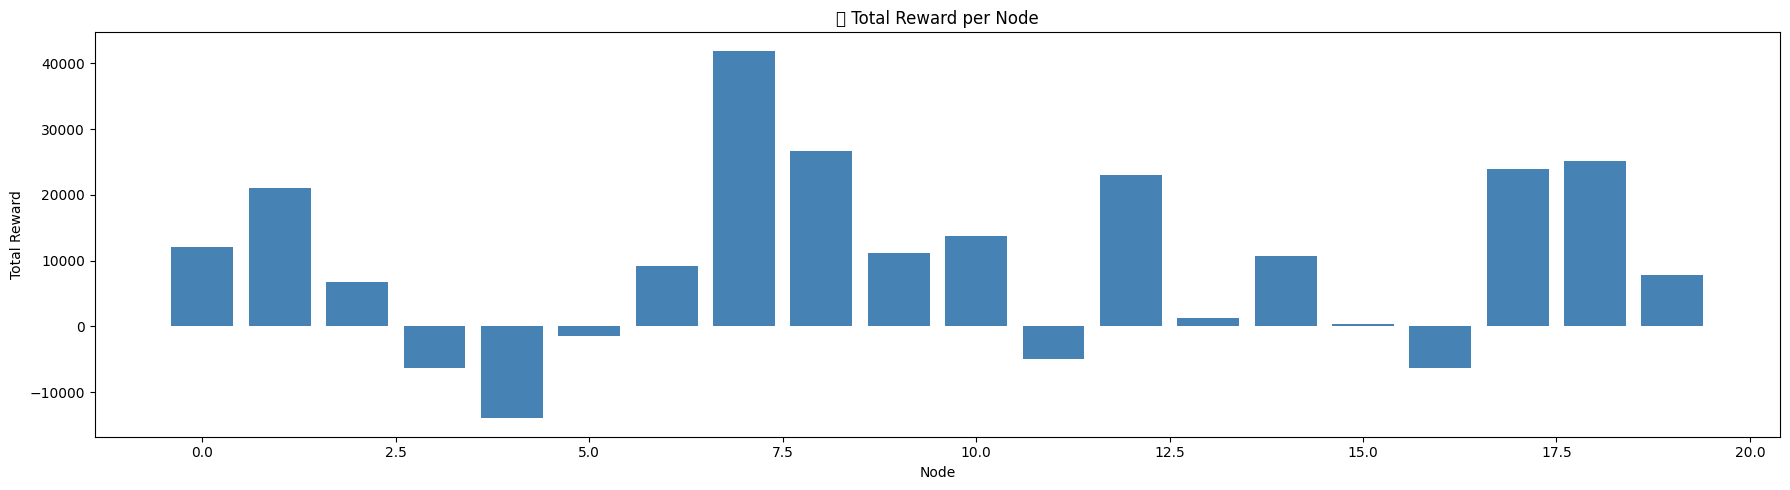

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(18, 5))

# Total reward per node
axes.bar(training_stats['node_rewards'].keys(), training_stats['node_rewards'].values(), color='steelblue')
axes.set_title('🪙 Total Reward per Node')
axes.set_xlabel('Node')
axes.set_ylabel('Total Reward')

plt.tight_layout()
plt.show()

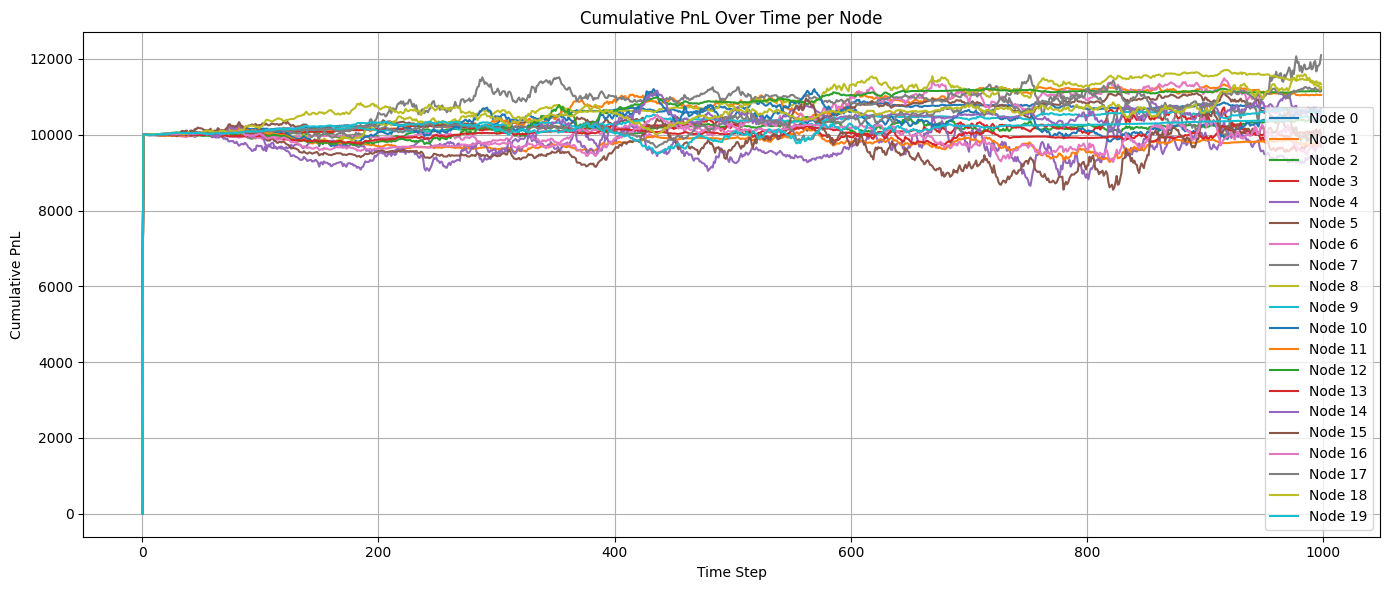

In [31]:
# Plot cumulative PnL
plt.figure(figsize=(14, 6))
for node in nodes:
    plt.plot(range(n_time_steps), cumulative_pnl_per_node[node], label=f'Node {node}')

plt.title('Cumulative PnL Over Time per Node')
plt.xlabel('Time Step')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()